<a href="https://colab.research.google.com/github/markmilner21/Assessement_0-Data-Review/blob/main/MarkM/Swish_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Swish

In this section, we will investigate the Swish Activation function and assess how performance levels differ as we tune different hyperparameters. The document is structured as follows.

**Table of Contents**
- [0. Necessary Imports](#0-imports)
- [1. Requirements](#1-requirements)
    - [1.1 Data Augmentation](#11-data-augmentation)
    - [1.2 Train and Test splitting](#12-checking-for-duplicates)
    - [1.3 Train:Validation split](#13-train-validation-split)
- [2. Investigation](#2-investigation)
    - [2.1 Introduction to Swish Activation Function](#21-introduction-to-swish)
    - [2.2 Parameter-Specific Evaluations](#21-parameter-specific-evaluations)
        - [2.2.1 Hyperparameters Tuning](#221-hyperparameters-tuning)
            - [2.2.1.1 Epochs and Batch Size](#2211-epoch-and-batch-size)
            - [2.2.1.2 Learning Rate](#2212-learning-rate)
            - [2.2.1.3 Swish learnable parameter](#2213-learnable)
- [3. Final Model Testing](#3-model-testing)
- [4. Conclusion](#4-conclusion)
- [5. References](#5-references)






<!-- - [2.2.2 Network Architecture](#221-network-architecture)
            - [2.2.2.1 Number of layers](#2.2.2.1-number-of-layers)
            - [2.2.2.2 Width](#2.2.2.2-width)
    - [2.3 Additional Techniques and Enhancements](#22-additional-techniques-and-enhancements)
         - INSERT -->

# 0. Necessary Imports

Here, we outline all the necessary imports required to run this file.

In [1]:
from pathlib import Path  # Import pathlib to work with paths
import kagglehub
import os  # Import os module for file operations
import hashlib
import numpy as np
from tqdm import tqdm
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Requirements

This section outlines the preprocessing pipleine that we impliment for consistency. Here, we download the data, run the preprocessing script and then run the ImageDataGen which impliments augmentation with geometric transformations (i.e flips, shears, rotations, zooms etc, and brightness, contrast changes) as outlined in our exploratory data analysis.



## 1.1 Data Augmentation



In [2]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


100%|██████████| 149M/149M [00:02<00:00, 57.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


## 1.2 Train and Test Splitting

In [3]:
# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0,  # Randomly shift RGB channels (intensity)
    validation_split=0.2  # Use 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Use 'binary' for binary classification, 'categorical' otherwise
    subset = 'training',
    shuffle=True
)
print('Validation Data: ')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Use 'binary' for binary classification, 'categorical' otherwise
    subset = 'validation',
    shuffle=True
)
print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Training Data: 
Found 4571 images belonging to 4 classes.
Validation Data: 
Found 1141 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


## 1.3 Train:Validation split

To fine-tune hyperparameters and assess their impact on performance, we will split the training data into training and validation sets. There are many factors that can influence the choice of split such as data availability and model complexity. If the validation split is too large, then the remaining training data will be substantially smaller than the entire training set and so the model may not be trained on a sufficient volume of data for convergence of performance on training data. On the other hand, if the validation split is too small, hyperparameter tuning becomes more difficult and the incites we gain become less reliable meaning that we may choose a suboptimal model that does not translate to a higher performance in testing [1]. In the above block, we select an 80/20 train/validation split which is a common split for moderately large datasets, providing ample data for training while reserving enough data for validation.

# 2. Investigation

Now all necessary preorocessing has been completed, we can commence our investigation into the swift function.



## 2.1 Introduction to the Swish Activation Function

In this section, we will establish the mathematical principles that underpin the Swish activation function and therefore justify the reasoning behind its use in this particular application.

### A formal definition

Formally, the swish activation function is defined as:

$ f(x) = x \times sigmoid(αx) = \frac{x}{1+\exp(-αx)}  $

where α is either a constant or learnable parameter [3]. The choice of the scalar, α, works to adjust the degree of nonlinearity in the swish function. For example, consider below the various plots of swish for different values of α.









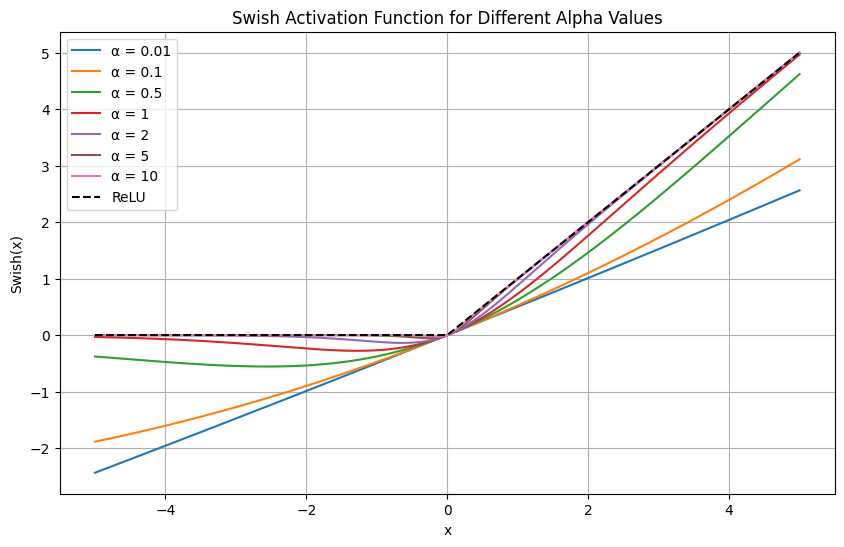

In [ ]:
# Define the Swish activation function with a variable alpha parameter
def swish_fun(x, alpha=1):
    return x * (1 / (1 + np.exp(-alpha * x)))

def relu_fun(x):
  return np.maximum(0,x)

x_values = np.linspace(-5, 5, 200) # Generate X vals

alpha_values = [0.01,0.1,0.5, 1, 2, 5, 10] # Define different alpha values

# Plot Swish activation functions for different alpha values
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    y_values = swish_fun(x_values, alpha)
    plt.plot(x_values, y_values, label=f'α = {alpha}')

plt.plot(x_values, relu_fun(x_values), label='ReLU', linestyle='--', color='black')

plt.title('Swish Activation Function for Different Alpha Values')
plt.xlabel('x')
plt.ylabel('Swish(x)')
plt.legend()
plt.grid(True)
plt.show()

As we see, as our choice of parameter tends towards 0, swish looks increasingly linear and looks like the linear function $x/2$ as $exp(-αx) ≈ 1$ hence $x/(1+exp(-αx)) ≈ x/2$.

For larger values of $α$, the swish function becomes increasingly like an indicator function. For example, for very large $α$, for negative $x$, $αx$ is large and negative and so $x/(1+exp(-αx))$ tends to 0 whereas for positive $x$, $αx$ is large and positive and so  $x/(1+exp(-αx))$ tends to $x$. With this insight, we have that swish approximates ReLU increasingly well as we increase the choice our parameter. Research of various implimentations of swish (as outlined below) suggest that $ α = 1 $ is a reasonable choice of parameter.


### Application Justification

Research of swish has shown that the activation function has shown promising performance in the domain of image classification. For example, on ImageNet, a large scale database containing millions of labeled images across thousands of categories [2], Swish has been shown to outperform ReLU, generally considered the best performing activation function in terms of accuracy [3]. Furthermore, a study by the National Institute of Technology Rourkela [4] whereby the VGG16 model, a popular CNN architecture developed out of the university of Oxford for image classificiation tasks [5] was modified with swish activation function over ReLU and showed higher levels across various performance metrics including accuracy, recall and specifictiy. Additionally, research into enhancing image classification for colorectal cancer by replacing ReLU for swish also led to improved accuracy rates.  Given Swish's proven capability in enhancing model performance on image classification tasks, it is therefore reasonable to consider Swish as a viable activation function for use in our application domain of classifying brain tumors. In order to impliment the algorithm, we will manually impliment the algorithm instead of importing it therby allowing us to manipulate and adapt the structure of the algorithm in order to perform out parameter-specific evaluations.

#### An alternative approach to ReLU

[insert]

## 2.2 Parameter-specific evaluations

In this section, we will perform hyperparameter tuning to assess how tweaking particular parameters within the Neural Network impact performance. In order to impliment this, we will need to a choose baseline model that we can build upon. as outlined previously, the VGG16 architecture is a popular convolution neural network architecture with 13 convolutional layers and 3 fully connected layers [5]. Let us begin by implimenting this model below. In order to impliment this architecture, we must modify the architecture slightly. The input shape of the original VGG16 model was images of size 224 x 224 whereas our image size is 64 x 64. To do this, we must have that inclde_top = False.

In [ ]:
# # Define the model using VGG16 as the base
# def create_vgg16_model(input_shape=(64, 64, 3), num_classes=4, includetop=False, learning_rate=0.001, lr_scheduler=None):
#     # Load the VGG16 model with pretrained weights, excluding the top (fully connected) layers
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

#     # Replace ReLU with Swish in the convolutional layers
#     for layer in base_model.layers:
#         if isinstance(layer, layers.Conv2D):  # Check for Conv2D layers
#             layer.activation = swish  # Replace ReLU with Swish

#     # Freeze the convolutional base to retain pretrained weights
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Add custom layers on top of the base model
#     x = base_model.output
#     x = layers.Flatten()(x)  # Flatten the 4D output from the base model to 1D
#     x = layers.Dense(512)(x)  # Add a dense layer
#     x = layers.Activation(swish)(x)  # Apply Swish activation to the dense layer
#     x = layers.Dropout(0.5)(x)  # Add dropout to prevent overfitting
#     output = layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

#     # Create the final model
#     model = models.Model(inputs=base_model.input, outputs=output)

#     if lr_scheduler:
#       model.compile(optimizer=Adam(learning_rate=lr_scheduler),loss='categorical_crossentropy',metrics=['accuracy']) # dynamic learning rate
#     else:
#       model.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy']) # static learning rate

#     return model


In [8]:
# Function to create the VGG16-like model with 13 convolutional layers and Swish activation
def create_vgg16_swish_model(input_shape=(64, 64, 3), num_classes=4, initial_learning_rate=0.001, lr_scheduler=None):
    model = models.Sequential()

    # Block 1: 2 Conv layers with 64 filters and Swish activation
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='swish', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: 2 Conv layers with 128 filters and Swish activation
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: 2 Conv layers with 256 filters and Swish activation
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 5: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='swish'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from the last convolutional block
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256, activation='swish'))
    model.add(layers.Dense(256, activation='swish'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax

    # Compile the model with the chosen learning rate and scheduler
    if lr_scheduler:
        model.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
epoch_count = 30

In [ ]:
base_model = create_vgg16_swish_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = base_model.fit(train_generator,epochs=epoch_count,validation_data=validation_generator)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.2717 - loss: 1.5082 - val_accuracy: 0.3357 - val_loss: 1.3972
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.3093 - loss: 1.9465 - val_accuracy: 0.3339 - val_loss: 1.3493
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3662 - loss: 1.2934 - val_accuracy: 0.3339 - val_loss: 1.3459
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.3496 - loss: 1.2954 - val_accuracy: 0.3374 - val_loss: 1.3259
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.3754 - loss: 1.2753 - val_accuracy: 0.3015 - val_loss: 1.3270
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.3606 - loss: 1.2883 - val_accuracy: 0.3602 - val_loss: 1.2993
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3698 - loss: 1.2774 - val_accuracy: 0.3427 - val_loss: 1.3254
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.3568 - loss: 1.2825 - val_accuracy: 0.342

In [ ]:
# Print a summary of the model architecture
base_model.summary()

[INSERT COMMENTS ABOUT THE BASELINE MODEL STRUCTURE]

### Baseline Performance Analysis

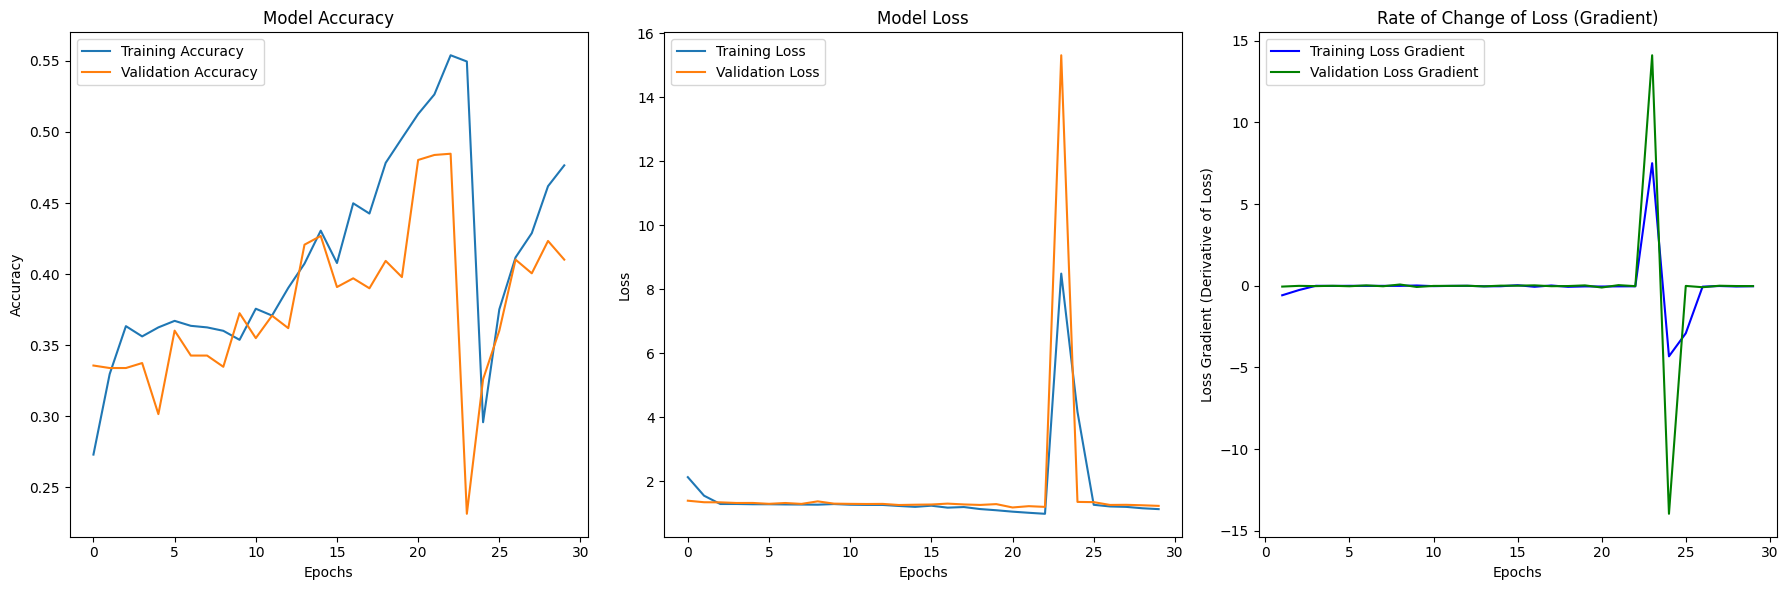

In [ ]:
def plot_training_history(history):
    """
    Plots the training accuracy, validation accuracy, training loss,
    validation loss, and the rate of change of the training loss (gradient)
    over epochs.

    Parameters:
    - history: The history object returned by model.fit(), which contains
               accuracy, loss, and other metrics over the epochs.
    """
    # Extract accuracy and loss data from history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the learning rates (if you have used a learning rate scheduler)
    learning_rate = history.history.get('lr', [0.001] * len(train_loss))  # Default to 0.001 if not available

    # Calculate the rate of change (gradient) of the loss
    train_loss_gradients = [train_loss[i] - train_loss[i-1] for i in range(1, len(train_loss))]
    val_loss_gradients = [val_loss[i] - val_loss[i-1] for i in range(1, len(val_loss))]

    # Plot the Accuracy, Loss, and Loss Gradient
    plt.figure(figsize=(18, 6))

    # Accuracy plot
    plt.subplot(1, 3, 1)  # Create a subplot (1 row, 3 columns, 1st plot)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 3, 2)  # Create a subplot (1 row, 3 columns, 2nd plot)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Loss Gradient plot
    plt.subplot(1, 3, 3)  # Create a subplot (1 row, 3 columns, 3rd plot)
    plt.plot(range(1, len(train_loss_gradients) + 1), train_loss_gradients, label='Training Loss Gradient', color='b')
    plt.plot(range(1, len(val_loss_gradients) + 1), val_loss_gradients, label='Validation Loss Gradient', color='g')
    plt.title('Rate of Change of Loss (Gradient)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Gradient (Derivative of Loss)')
    plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

plot_training_history(history)

The 3 plots above display how the model learned over time. the first plot displays model accuracy (the proportion of data correctly classified) over each epoch. As we see model accuracy increased over time which is what we expect as the model becomes more 'familar' with the data and tunes itself accordigly. Although... Similarly, the central plot displays the loss function against epochs. As we see, the loss function for the training data reduced very slightly. We see that the validation data is less consistent and that the model validation accuracy and loss fluxuates more than the training loss. Intuitevly, this is expected since the validation data is used to test the model on unseen data which may contain data that the model has not yet encountered during training. Consequentally, the validation performance metrics fluxuate as the model hasn't fully generalised yet.

In [4]:


def plot_training_history_multiple_models(histories, labels=None):
    """
    Plots the training accuracy, validation accuracy, training loss,
    validation loss, and the rate of change of the training loss (gradient)
    over epochs for multiple models.

    Parameters:
    - histories: A list of history objects (one per model) returned by model.fit().
    - labels: Optional list of labels for each model, for legend purposes.
    """
    # Check if we have labels, if not, create generic labels
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(histories))]

    # Set up subplots
    plt.figure(figsize=(18, 10))

    # Iterate over all models and plot the training history
    for i, history in enumerate(histories):
        # Extract accuracy and loss data from history
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Get the learning rates (if you have used a learning rate scheduler)
        learning_rate = history.history.get('lr', [0.001] * len(train_loss))  # Default to 0.001 if not available

        # Calculate the rate of change (gradient) of the loss
        train_loss_gradients = [train_loss[j] - train_loss[j-1] for j in range(1, len(train_loss))]
        val_loss_gradients = [val_loss[j] - val_loss[j-1] for j in range(1, len(val_loss))]

        # Plot training accuracy (subplot 1)
        plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st plot
        plt.plot(train_accuracy, label=f'Training Accuracy ({labels[i]})')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot validation accuracy (subplot 2)
        plt.subplot(2, 3, 2)  # 2 rows, 3 columns, 2nd plot
        plt.plot(val_accuracy, label=f'Validation Accuracy ({labels[i]})')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training loss (subplot 3)
        plt.subplot(2, 3, 3)  # 2 rows, 3 columns, 3rd plot
        plt.plot(train_loss, label=f'Training Loss ({labels[i]})')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation loss (subplot 4)
        plt.subplot(2, 3, 4)  # 2 rows, 3 columns, 4th plot
        plt.plot(val_loss, label=f'Validation Loss ({labels[i]})')
        plt.title('Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training loss gradient (subplot 5)
        # plt.subplot(2, 3, 5)  # 2 rows, 3 columns, 5th plot
        # plt.plot(range(1, len(train_loss_gradients) + 1), train_loss_gradients, label=f'Training Loss Gradient ({labels[i]})')
        # plt.title('Training Loss Gradient')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss Gradient')
        # plt.legend()

        # # Plot validation loss gradient (subplot 6)
        # plt.subplot(2, 3, 6)  # 2 rows, 3 columns, 6th plot
        # plt.plot(range(1, len(val_loss_gradients) + 1), val_loss_gradients, label=f'Validation Loss Gradient ({labels[i]})')
        # plt.title('Validation Loss Gradient')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss Gradient')
        # plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Example usage
# VALS = [history]  # A list of history objects
# labels = ['Model 1']
# plot_training_history_multiple_models(VALS, labels)

### 2.2.1 Hyperparameter Tuning

In this section, we will directly change various hyperparameters in our model as assess how this impacts performance.

#### 2.2.1.1 Epochs and Batch size

We will begin by change the number of epochs and the batch size in our model. Let us begin by defining these parameters.

An Epoch simply refer to a complete pass through the entire training dataset. In our initial model, we set the total number of epochs to 10. Essentially, in this section, we are hoping to find the optimal balance between our training time (which we want to reduce) and validation accuracy levels (which we want to increase). This balance is achieved when the accuracy plateaus, signaling that further training will not yield any significant validation accuracy improvements. Furthermore, too many epochs can lead to overfitting as the model begins to memorise the training data and too few epochs can lead to underfitting where the model has not yet had sufficient time to learn the data [8].

batch size refers to the number of training rows that the model intakes before updating it's weights. In our case, the default value for batch size is 32. In our image classification problem, this would be the model would consider 32 images before making any weight adjustments.

Due to time-constraints, we will first begin our epoch investigation by considering training the same base model over 10, 25 and 50 epochs to assess how performance is impacted with the addition of more epochs. Ideally, we would prefer to test the model on more than this but given GPU limitations on colab, this will have to suffice.

#### Epochs



In [ ]:
history_of_models_epochs = []
epoch_counts = [10,25,50]
for epochs in epoch_counts:
  print(f'Epochs: {epochs}')
  base_model = create_vgg16_swish_model()
  history = base_model.fit(train_generator,  # Generator for training data
    epochs=epochs,        # Number of epochs
    validation_data=validation_generator)  # Generator for validation data), callbacks=[early_stopping])
  history_of_models_epochs.append(history)
  print('')

Epochs: 10
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.2726 - loss: 1.3915 - val_accuracy: 0.2796 - val_loss: 4.0769
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.2571 - loss: 1.7335 - val_accuracy: 0.2550 - val_loss: 1.3975
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.2739 - loss: 2.8339 - val_accuracy: 0.2550 - val_loss: 1.3846
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.2730 - loss: 1.3845 - val_accuracy: 0.2796 - val_loss: 1.3835
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.2746 - loss: 1.3836 - val_accuracy: 0.2796 - val_loss: 1.3834
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.2685 - loss: 1.3853 - val_accuracy: 0.2796 - val_loss: 1.3833
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.2771 - loss: 1.3843 - val_accuracy: 0.2796 - val_loss: 1.3833
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.2752 - loss: 1.3844 - val_accuracy: 0.279

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.2761 - loss: 1.4122 - val_accuracy: 0.2314 - val_loss: 1.4055
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3081 - loss: 1.3416 - val_accuracy: 0.2559 - val_loss: 1.4047
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.3603 - loss: 1.3175 - val_accuracy: 0.3295 - val_loss: 1.3339
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.3767 - loss: 1.2594 - val_accuracy: 0.2629 - val_loss: 1.3744
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.2727 - loss: 1.4156 - val_accuracy: 0.2936 - val_loss: 1.3749
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.3439 - loss: 1.3177 - val_accuracy: 0.3734 - val_loss: 1.4029
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.4724 - loss: 1.0661 - val_accuracy: 0.4032 - val_loss: 1.2127
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.5126 - loss: 0.9993 - val_accu

KeyboardInterrupt: 

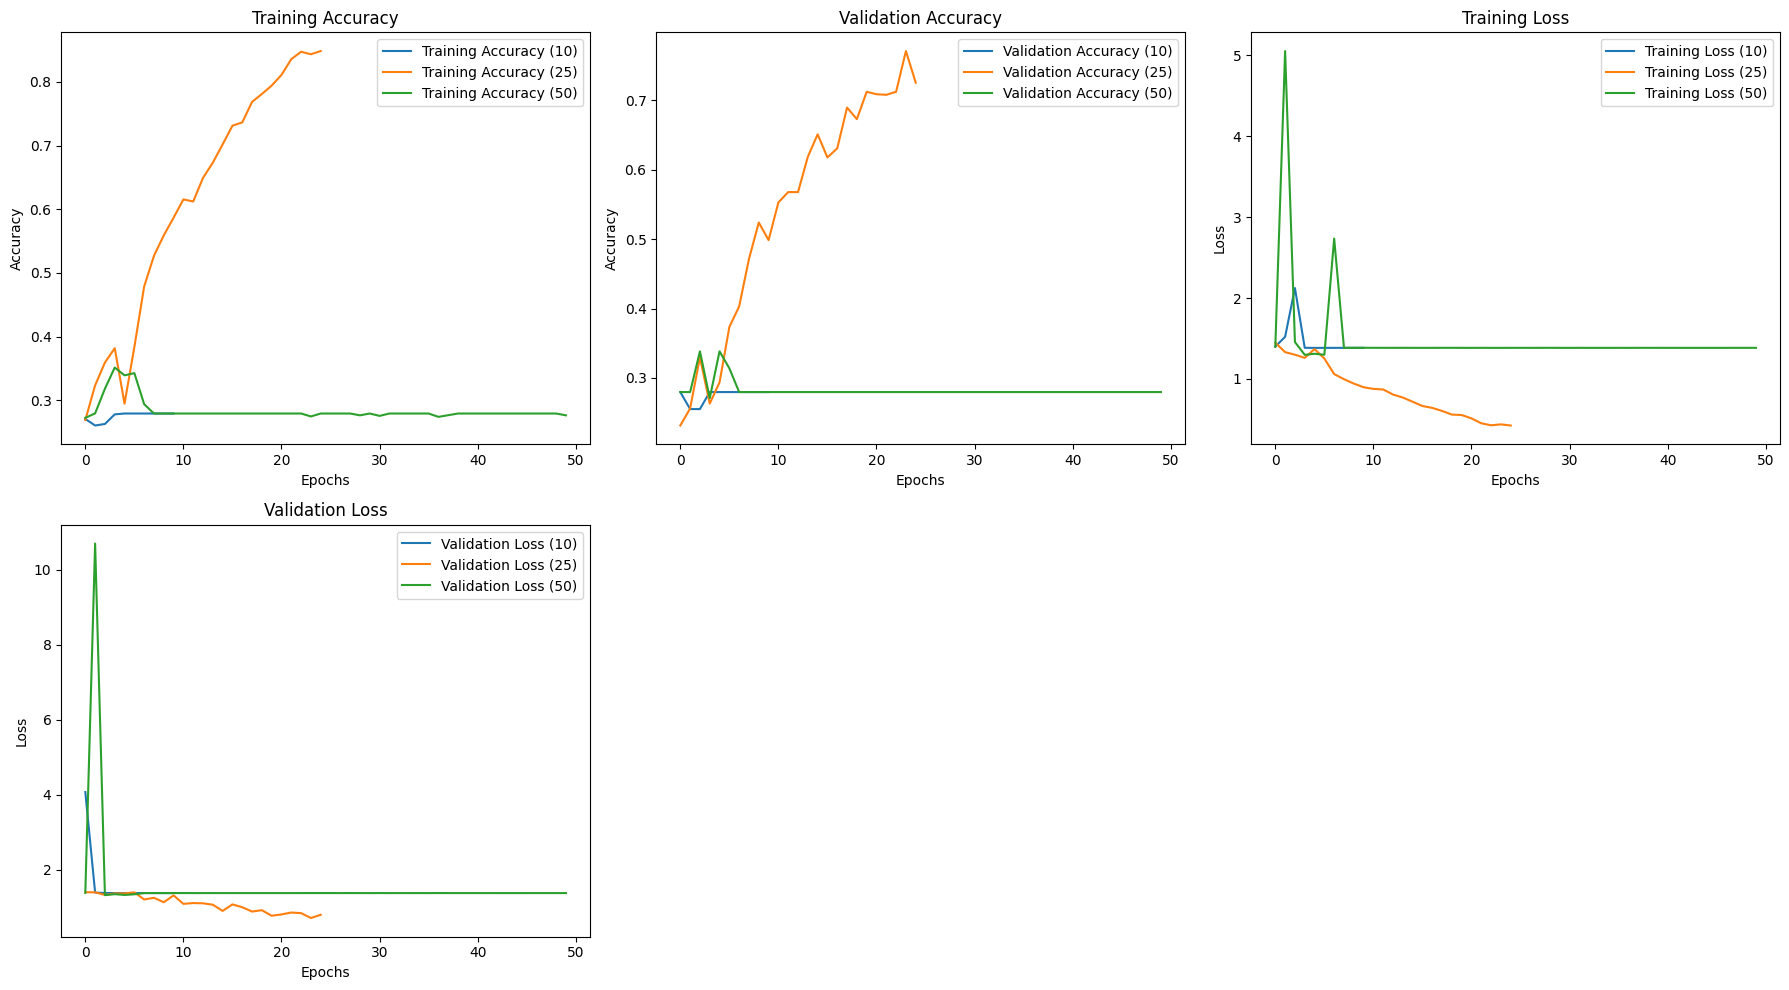

In [ ]:
plot_training_history_multiple_models(history_of_models_epochs, epoch_counts)

Here, we see the best performing model was when we ran the model with 25 epochs.We see that in the case of the 10-epoch model, metrics only marginally improved with the model maintaing a validation accuracy of 0.2796 over multiple epochs. This suggests that perhaps the model was not given sufficient time to generalise to unseen validation data. We saw a much improved performance from the 25 epoch model which managed to reach a validation accuracy of 0.7257 and a training accuracy of 0.8474. Strangely, when we increased the epochs further (see either our initial base model that ran over 30 epochs or our 50-epoch model), the performance worsened and particularly in the case of our 50-epoch model, returned to performance levels similar to that of the 10-epoch model. This could be due to a multitude of reasons. For example, the model could be overfitting where the model is essentially memorising the training data however the relatively poor performance on the training data suggest otherwise. Whatever the case, this result benefits us as it speeds up run-time and it would not be possible to perform more than 25 epochs given our time-constraints anyway.

In [5]:
epoch_count = 25

#### Batch Size

In [ ]:
batch_sizes = [8,16,32,64,128]
history_of_models_batches = []
for batch_size in batch_sizes:
  print('Batch Size: ',batch_size)
  model = create_vgg16_swish_model()
  history = model.fit(train_generator,epochs=epoch_count,validation_data=validation_generator,batch_size=batch_size)
  history_of_models_batches.append(history)
  print('')

Batch Size:  8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.2612 - loss: 1.4411 - val_accuracy: 0.2340 - val_loss: 1.4363
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.3213 - loss: 1.3518 - val_accuracy: 0.3111 - val_loss: 1.3744
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.3443 - loss: 1.3611 - val_accuracy: 0.2340 - val_loss: 1.3890
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.2618 - loss: 1.3852 - val_accuracy: 0.2796 - val_loss: 1.3836
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.2665 - loss: 1.3850 - val_accuracy: 0.2796 - val_loss: 1.3840
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.2915 - loss: 1.3760 - val_accuracy: 0.2796 - val_loss: 1.3755
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.3019 - loss: 1.3551 - val_accuracy: 0.3111 - val_loss: 1.3359
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.3773 - loss: 1.2874 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.2631 - loss: 1.4091 - val_accuracy: 0.2743 - val_loss: 1.3822
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.2882 - loss: 1.3700 - val_accuracy: 0.2796 - val_loss: 1.3836
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.2845 - loss: 1.3832 - val_accuracy: 0.2796 - val_loss: 1.3803
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.2792 - loss: 1.3810 - val_accuracy: 0.2796 - val_loss: 1.3835
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.2721 - loss: 2.3665 - val_accuracy: 0.2550 - val_loss: 9.2159
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.2758 - loss: 11.3943 - val_accuracy: 0.3295 - val_loss: 1.3563
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3660 - loss: 1.2965 - val_accuracy: 0.3488 - val_loss: 1.3294
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.3420 - loss: 

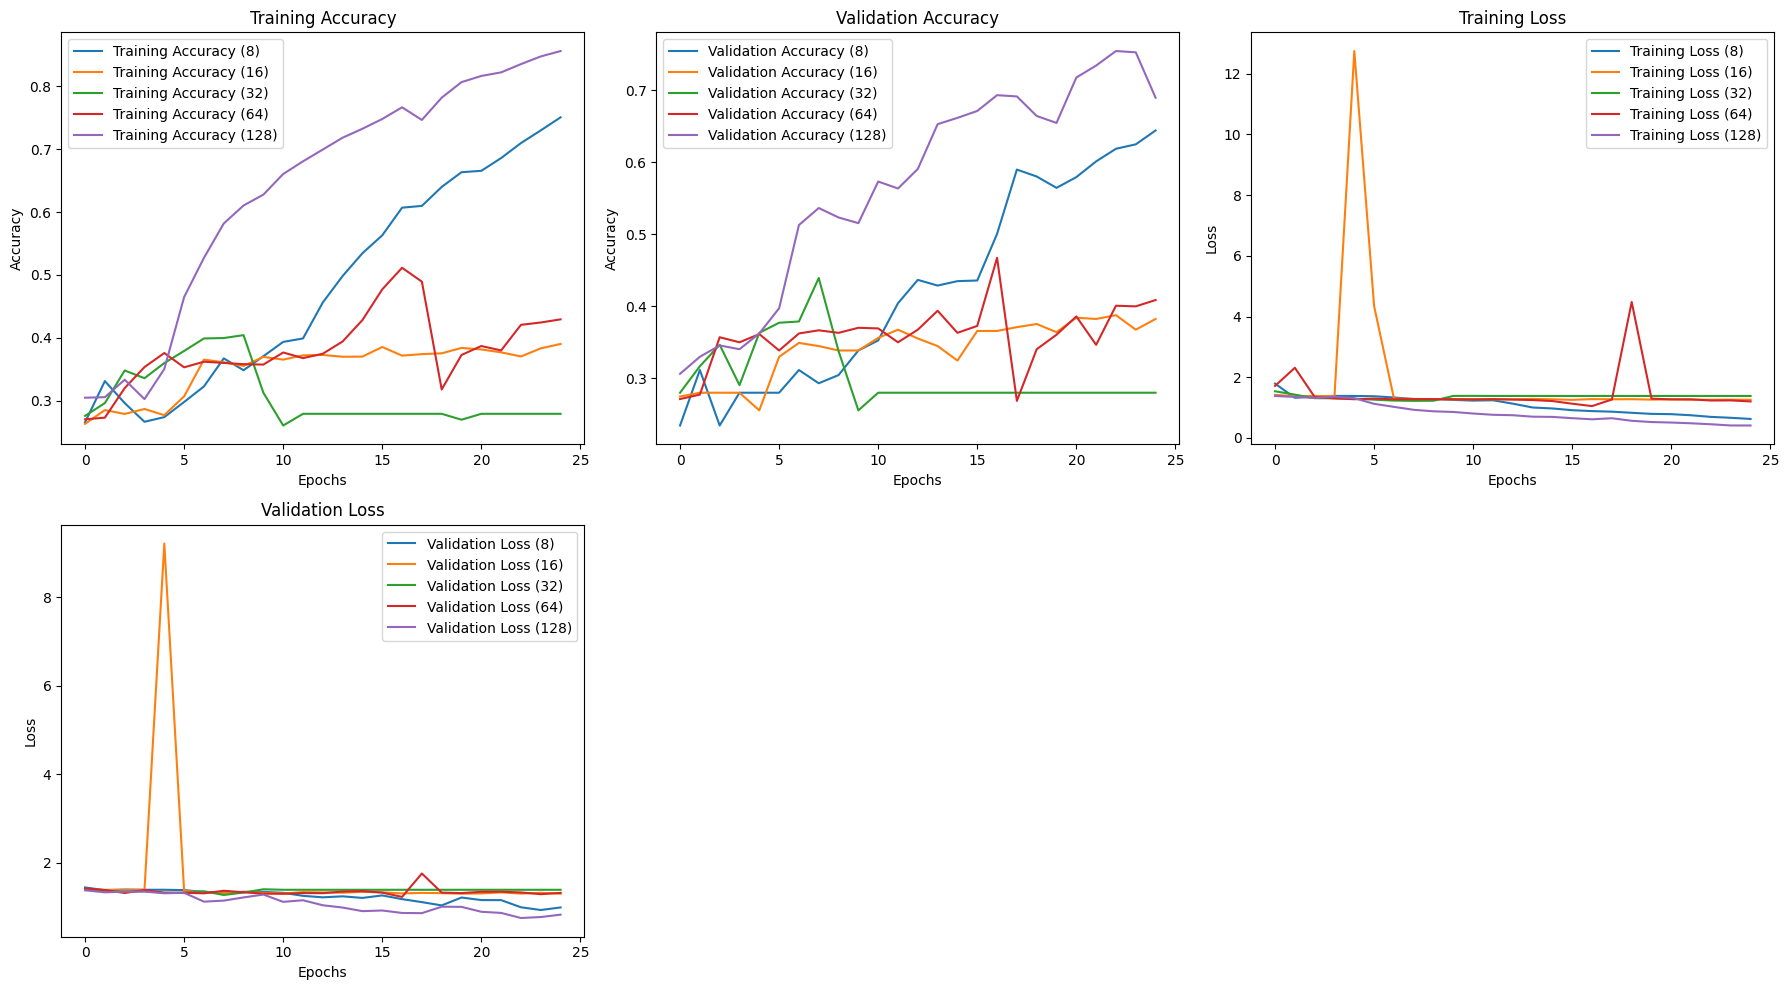

In [ ]:
plot_training_history_multiple_models(history_of_models_batches, batch_sizes)

#### 2.2.1.2 Learning Rate

In this section, we will modify and attempt to find an optimal value for our learning rate. In our baseline model, we used a static learning rate with value of 0.001 with an ADAM optimizer. We explore the details of stochastic gradient descent and implementations that use an adaptive learning rate in our section on the [ReLU activation function](https://github.com/vivekp12/dst-group-project-2/blob/main/VivekP/04-ReLUInvestigation.ipynb). As mentioned, the implementation of a dynamic learning rate enables a better tradeoff between exploration and exploitation, facilitating convergence to (at least) a local minimum loss. A large static learning rate can accelerate the model's exploration of the loss landscape, potentially speeding up training. However, it may cause the model to overshoot or skip over optimal minima and lead to divergent behaviour [9][10]. On the other hand, a small static learning rate reduces the model exploration, leading to more gradual updates. While this means the model may require more epochs to fully converge and reach optimal performance, it allows for more accurate convergence on a minimum, as it makes smaller, more precise adjustments to the parameters.![Learning Rate Example](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png). We will consider various different dynamic learning rate algorithms, comparing their methodology and then establish which of them leads to the highest performance. Below, we list the various methods we will impliment to experiment with different learning rate scheduling techniques alongside a static learning rate model which will act as a sort of control test.

## Warm Restarts

Warm restarts refers to the periodic resetting of the learning rate following a phase of decay, the theory behind this being that the re-raising of the learning rate allows the model to jump out of flat or undesirable regions in the loss surface, working to escape any local minima in an attempt to find a global minima therefore potentially leading to improved accuracy scores. Review of various literature published on warm restarts has suggested that in the application domain of image classification, implimenting warm restarts with cosine annealing [11] or with a polynomial learning rate [12] can lead to improved results compared to models that impliment learning rates with step-wise decay. The original paper published by Loshchilov & Hutter [11] performed warm restart models on various image classification datasets such as ImageNet [13] as well CIFAR-10 and CIFAR-100 [14]. The conclusion of this paper suggested that implimentation of warm restarts worked to speed up convergence by a factor of two to four as this helped to escape poor local minima and flat regions of the loss surface. Additionally, whilst warm restarts were initially applied to the Stochastic Gradient Descent activation function (SGD), the authors suggest that future work should consider warm restarts for other popular training algorithms such as AdaDelta and namely, Adam, the activation function we impliment in this project. Furthermore, by resetting the learning rate, the classical problem of selecting an optimal learning rate is addressed as the model can explore different ranges during training as opposed to following a monotonically decreasing function [15]. A paper published by the
Indian Institute of Technology [12] has suggested that implimentation of polynomial decay learning rate with a single warm restart can obtain better classification accuracy as well as facilitating faster optimization on CIFAR and imagenet.

We will impliment the following Learning rate schedulers in our analysis:


#### 1. Exponential Decay

Exponential Decay is a method of iteratively annealing the learning rate over time (i.e. per epoch or per batch) from an initial large value which allows for faster convergence on a minimum training loss and then as training progresses, the value of the learning rate is reduced by a fixed factor to prevent stepping over the minimum and thus allowing for a precice convergence. The rate of decay is defined:

#### 2. ReduceLROnPlateau

ReduceLROnPlateau works by following a metric (e.g. validation loss) and updates the learning rate when this metric plateaus. This method is helpful when the model has "stagnated" during training and you want to encourage it to find better local minima by taking smaller steps. For example, consider the right plot in the above diagram which steps over the minimum. Essentially, the model can take large steps if they are resulting in a reduction in terms of loss but when progress stalls and the loss plateaus, the learning rate can adjust itself. Hence, this allows for fast exploration when progress is being made and prevents overshooting the optimal solution.

#### 3. Cosine Annealing w/ warm restarts [11][16]

Cosine annealing operates similarly to exponential decay however instead of decaying according to an exponential function, the annealing process follows a cosine function. See below for a more in-depth description.

#### 4. Polynomial Learning Rate w/ warm restarts [12][17]

Similarly to Cosine and Exponential Decay, this process involves the decaying of the learning rate as we attempt to hone in on a minima.

#### 5. Static Learning Rate

As aforementioned, we will impliment 2 models with static learning rates to show how the dynamic learning rate models fair against models that are not configured specifically to converge on a minimum by adjusting their learning rate decromentally over time. For one, our base model is designed with a small static learning rate of 0.001. We will also impliment a model with a large static learning rate. This means that the 'steps' that the model makes along the loss function are larger allowing for greater exploration of the loss space but makes convergence more difficult. This model will have a learning rate of 0.1. Comparing the two static models, this means that in practice, the updating of the weights operates as follows:

$$w_{t+1} = w_t - \eta \cdot \nabla L(w_t)$$

where

- $ w_t $: The weights or parameters of the model at step $ t $.
- $ \nabla L(w_t) $: The gradient of the loss function $ L(w) $ with respect to the weights $ w_t $.
- $ \eta $: The learning rate
- $ w_{t+1} $: The updated weights after applying the gradient step.







In [6]:
def print_lr(epoch, logs):
    lr = current_model.optimizer.learning_rate
    print('')
    print(f"Epoch {epoch+1}: Learning rate is {lr.numpy()}")

# Create a custom callback to print the learning rate
display_lr = tf.keras.callbacks.LambdaCallback(on_epoch_end=print_lr)

### Exponential decay implimentation

here, you want to talk about choice of decay steps, decay rate and initial learning rate.

In [ ]:
epoch_count = 25
train_samples = len(train_generator)
batch_size = 32
steps_per_epoch = train_samples // batch_size
decay_steps = steps_per_epoch * epoch_count

# Define the learning rate scheduler with exponential decay
initial_learning_rate = 0.01
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,  # Decay over the entire training process
    decay_rate=0.96,          # Reduce by 4% every decay step
   # staircase=True            # Decay in discrete steps (instead of continuously)
)

exp_lr_model = create_vgg16_swish_model(lr_scheduler=lr_scheduler)
current_model = exp_lr_model
history_exp = exp_lr_model.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator,
                    callbacks=[display_lr])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2348 - loss: 743441865226846208.0000
Epoch 1: Learning rate is 0.09432957321405411
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.2349 - loss: 736316686281474048.0000 - val_accuracy: 0.2796 - val_loss: 1.3950
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2547 - loss: 1.4385
Epoch 2: Learning rate is 0.08898067474365234
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - accuracy: 0.2547 - loss: 1.4385 - val_accuracy: 0.2550 - val_loss: 1.4437
Epoch 3/25
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2556 - loss: 1.4610
Epoch 3: Learning rate is 0.08393508940935135
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.2556 - loss: 1.4608 - val_accuracy: 0.2796 - val_loss: 1.3910
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2411 - loss: 1.4237
Epoch 4: Learning rate is 0.07917561382055283
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.2412 - loss: 1.

### ReduceLROnPlateau implimentation

Currently, TensorFlow does not provide a direct learning rate schedule within the tf.keras.optimizers.schedules module (like ExponentialDecay). The ReduceLROnPlateau callback is the primary method for achieving this LR behavior. Learning rate schedules are predefined rules for adjusting the learning rate over time based on the number of steps or epochs. This method
doesn't follow a regular time-based schedule but reacts to metrics (like validation loss or accuracy) during training. It adapts the learning rate when a plateau in the performance metric is detected as opposed to adapting in fixed time intervals. In theory, this can lead to improved performance, as the learning rate is dynamically adjusted based on the model’s behavior, rather than following a predetermined schedule.

In [10]:
# Set up the ReduceLROnPlateau scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor (e.g., validation loss)
    factor=0.5,                # Factor by which to reduce the learning rate
    patience=3,               # Number of epochs with no improvement after which learning rate is reduced
    min_lr=1e-6,               # Minimum learning rate, it won't go lower than this value
    verbose=0                  # Print out when the learning rate is reduced
)

RLOP_model = create_vgg16_model()
history_rlop = RLOP_model.fit(train_generator,
          epochs=epoch_count,
          validation_data=validation_generator,
          callbacks=[lr_scheduler, display_lr],  # Add the scheduler as a callback
          verbose=1)


NameError: name 'create_vgg16_model' is not defined

### Cosine Decay w/ warm restarts implimentation

In this section, we'll impliment cosine decay with and without warm restarts. This way, not only can we compare its performance with the other learning rate schedulers but also assess how impactful warm restarts is in terms of model performance and optimisation efficiency. This method of Cosine Annealing reduces the learning rate following a cosine function over a predefined number of epochs. Similar to exponential decay, the learning rate starts larger and is reduced according to the cosine function. Mathematically, the learning rate calculation occurs as follows [18]:

$
\eta(t) = \eta_{\min} + \frac{1}{2} (\eta_{\max} - \eta_{\min}) \left( 1 + \cos \left( \frac{t * \pi}{T_{\text{max}}} \right) \right)
$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate,
- $T_{\text{max}}$ is the total number of iterations or epochs,
- $t$ is the current step or iteration.

The below image is an implimentation of cosine annealing with warm restarts. From this red line, it is clear how cosine annealing with warm restarts takes occurs.

![Cosine Annealing](cosine_annealing.png)[19]

The formula for cosine annealing with warm restarts can be written as [11]:

$$
\eta(t) = \eta_{\min} + \frac{1}{2} (\eta_{\max} - \eta_{\min}) \left( 1 + \cos \left( \frac{T_{\text{cur}}}{T_i} \pi \right) \right)
$$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate,
- $T_{\text{cur}}$ is the current iteration or time step since the last restart,
- $T_i$ is the total number of epochs in that cycle.

The formula given applies to a single cycle in the process of annealing where the $i$-th cycle corresponds to the $i$-th restart of the learning rate.
Essentially, After $T_i$ epochs, the learning rate is reset to its maximum value and then follows the cosine annealing decay for the next $T_{i+1}$ epochs.

  









### Without Warm Restarts

In [ ]:
# Define the Cosine Decay learning rate schedule
initial_learning_rate = 0.001  # Initial learning rate
decay_steps = decay_steps  # Number of steps for the learning rate to decay
alpha = 0.0  # Minimum learning rate value (usually set to 0.0)

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha,  # Minimum learning rate at the end of decay
    name='CosineDecay'
)

# Create and compile the model
cos_model = create_vgg16_model(lr_scheduler=lr_scheduler)

# Train the model
history_cos = cos_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]  # Assuming display_lr is your learning rate display callback
)

### With Warm Restarts

In [ ]:
# Define the CosineDecayRestarts learning rate schedule
initial_learning_rate = 0.001
first_decay_steps = 32*epoch_count  # Number of steps for the first restart (typically corresponds to your batch size * epochs)
t_mul = 2.0  # Factor by which the decay period increases after each restart
m_mul = 1.0  # Multiplier for the maximum learning rate after each restart (set to 1 for no increase)
alpha = 0.0001  # Minimum learning rate value after each restart (you can adjust this to a small value like 0.0001)

lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=t_mul,
    m_mul=m_mul,
    alpha=alpha,
    name='SGDRDecay'
)
# Create and compile the model
cosr_model = create_vgg16_model(lr_scheduler=lr_scheduler)

# Train the model
history_cosr = cos_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]  # Assuming display_lr is your learning rate display callback
)


### Polynomial Decay w/ warm restarts

We also impliment polynomial decay with and without warm restarts.

The polynomial learning rate decay formula is given by:

$$
\eta(t) = \eta_{\min} + (\eta_{\max} - \eta_{\min}) \left( 1 - \frac{t}{T} \right)^p
$$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate,
- $t$ is the current epoch,
- $T$ is the total number of epochs over which the learning rate decays,
- $p$ is the polynomial power controlling the decay rate. According to [12], a power of 0.9 has proved the most succeful in terms of model accuracy and optimisation speed when tested on the CIFAR-100 dataset.

The polynomial learning rate decay with warm restarts formula is given by:

$$
\eta(t) = \eta_{\min} + (\eta_{\max} - \eta_{\min}) \left( 1 - \frac{T_{\text{cur}}}{T_i} \right)^p
$$

Where:
- $\eta(t)$ is the learning rate at time step $t$,
- $\eta_{\min}$ is the minimum learning rate,
- $\eta_{\max}$ is the maximum learning rate, which is reset after each warm restart,
- $T_{\text{cur}}$ is the current time step (or epoch) within the $i$-th cycle,
- $T_i$ is the total number of iterations (or epochs) in the $i$-th cycle (i.e., between two warm restarts),
- $p$ is the polynomial power controlling the decay rate,
- $i$ is the cycle index, representing the $i$-th warm restart.

After every $T_i$ epochs, the learning rate is reset to $\eta_{\max}$ and the polynomial decay starts again for the next cycle. Different implimentations allow for the decay to restart from a lower initial value than before (for example, instead of starting at the maximum, you start at a fraction of this value according to how far into the training you are). Furthermore, research [12] found that the best results occured with a single restart after 25% of the total number of epochs were completed although also stated that "Asingle learning rate policy may not be universally applicable
 to any DNN model or dataset".



#### Without Warm Restarts

In [ ]:
end_learning_rate = 0.0001  # The final learning rate at the end of decay
power = 0.9  # Polynomial power, typically set to 1.0

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power,
    cycle=False,  # No restarts (just continuous decay)
    name='PolynomialDecay'
)

# Create and compile the model
poly_model = create_vgg16_model(lr_scheduler=lr_scheduler)

# Train the model
history_poly = poly_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]  # Assuming display_lr is your learning rate display callback
)



#### With Warm Restarts

In [ ]:
# Polynomial decay with warm restarts
def poly_restart_schedule(epoch, initial_learning_rate=0.001, decay_steps=decay_steps, end_learning_rate=0.0001, power=1.0, t_mul=2.0, m_mul=1.0):
    # Determine the current cycle and steps in the cycle
    cycle = int(epoch // decay_steps)  # This defines the current cycle
    current_step = epoch % decay_steps  # Steps within the current cycle
    cycle_steps = decay_steps * (t_mul ** cycle)  # Steps in the current cycle, which grows after each restart

    # Polynomial decay calculation
    decay_rate = 1 - (current_step / cycle_steps)
    learning_rate = end_learning_rate + (initial_learning_rate - end_learning_rate) * (decay_rate ** power)

    # Optionally adjust the learning rate with each restart (t_mul controls the increase in cycle length)
    learning_rate *= (m_mul ** cycle)

    return learning_rate

# Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(poly_restart_schedule)

# Create and compile the model (same as before)
polyr_model = create_vgg16_model(lr_scheduler=lr_scheduler)

# Train the model with warm restarts
history_polyr = poly_model.fit(
    train_generator,
    epochs=epoch_count,
    validation_data=validation_generator,
    callbacks=[display_lr]  # Assuming display_lr is your learning rate display callback
)


### Static Learning Rate Models

Below we impliment the static large learning rate model. Note once again that our initial base model operates as our static small learning rate model and will not be reimplimented here.

### Large Static Learning Rate implimentation

In [ ]:
large_static_model = create_vgg16_model(learning_rate=0.1)
history_largestat = large_static_model.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator, callbacks=[output_lr])

## Comparing Learning Rate Performances

We will now evaluate the performances of our algorithms to see which model performs the best in terms of our perfomance metric, accuracy. First, it is interesting to visualise how the learning rates change over time for all the models. Consider the following plot of all the learning rates as they change as training progresses.

In [ ]:
# prompt: i want to plot all the learning rate functions over the epochs including static model

plt.figure(figsize=(12, 8))

# Plot the learning rate for each model
plt.plot(history_exp.history['lr'], label='Exponential Decay')
plt.plot(history_rlop.history['lr'], label='ReduceLROnPlateau')
plt.plot(history_cos.history['lr'], label='Cosine Decay')
plt.plot(history_cosr.history['lr'], label='Cosine Decay with Restarts')
plt.plot(history_poly.history['lr'], label='Polynomial Decay')
plt.plot(history_polyr.history['lr'], label='Polynomial Decay with Restarts')
plt.plot(history_largestat.history['lr'], label='Large static = 0.1')
plt.plot(history.history['lr'], label='Small static = 0.001')


plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedules')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_results = [history, history_exp, history_rlop, history_cos, history_cosr, history_poly, history_polyr, history_largestat]
labels = ['small static', 'exponential decay', 'RLOP', 'cosine decay', 'cosine decay w/ WR', 'polynomial decay', 'polynomial decay w/ WR','large static']
plot_training_history_multiple_models(all_results, labels)

[INSERT]

#### 2.2.1.3 Swish's scalable parameter, $ α $.

In this section of our experiment. We are going to evaluate the performance of our base model whilst adapting Swish's learning parameter previously defined as $ \alpha $. As we saw earlier, the standard swish function defines $ \alpha = 1 $ and tends to a linear function as this parameter tends to 0 whilst becoming more and more ReLU-like as we increases $\alpha$. This value works to alter the flow of gradients as the scale of the parameter controls how fast the first derivative asymptotes to 0 and 1 [3]. We can see from our original swish plot, the non-monotonic “bump” of the swish function at small negative values of $x$.
This can be important when controlling how easy it is for the model to escape local minima during optimisation. Sources such as Google's paper, *searching for activation functions* [3] or independent researcher, Eric Alcaide's paper, *E-swish: Adjusting Activations to Different Network Depths* [18] have suggested that changing this parameter can have an important impact on model performance and optimisation speeds. Additionally, as will be seen by the below plots of Swish and its gradient curves for varying values of $ \alpha $, for certain values of this parameter, the gradient can become greater than 1 potentially leading to gradient exploding problems during backpropogation which is particularly problematic in deep architectures as the gradients are iteratively multiplied which can lead to very large weights that cause the loss to blow up. Similalarly, when this learnable parameter is said to a small positive value, the derivative function outputs smaller values and can lead to gradient vanishing problems in deep networks meaning the model performance barely improves over epochs as weights (particularly in early layers) barely change. Therefore, in either case, model performance is impacted. For this reason, the default parameter sets this value to 1 as it tends to provide a balance between model performance, computation time and does well in avoiding some of these aforementioned potential issues.



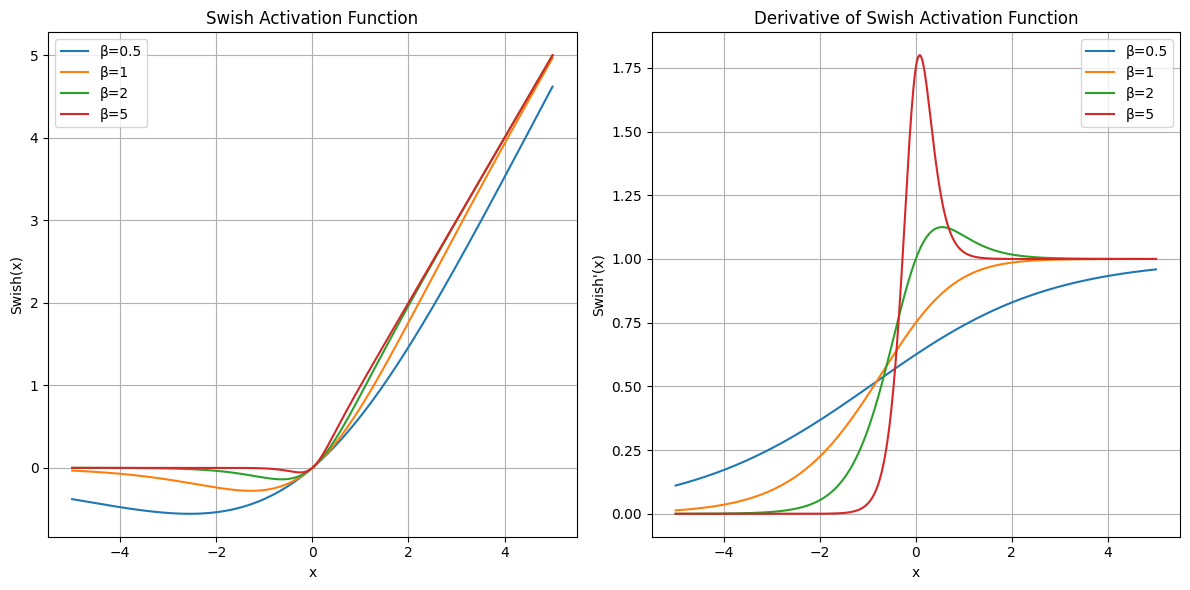

In [ ]:
# Define the derivative of Swish
def swish_derivative(x, beta):
    sigmoid = 1 / (1 + np.exp(-beta * x))
    return beta * sigmoid * (1 - sigmoid) + sigmoid

# Generate input values
x = np.linspace(-5, 5, 500)

# Define beta values to test
beta_values = [0.5, 1, 2, 5]

# Plot Swish functions and their derivatives
plt.figure(figsize=(12, 6))

# Swish Activation Plot
plt.subplot(1, 2, 1)
for beta in beta_values:
    y = swish_fun(x, beta)
    plt.plot(x, y, label=f"β={beta}")
plt.title("Swish Activation Function")
plt.xlabel("x")
plt.ylabel("Swish(x)")
plt.legend()
plt.grid()

# Swish Derivative Plot
plt.subplot(1, 2, 2)
for beta in beta_values:
    dy = swish_derivative(x, beta)
    plt.plot(x, dy, label=f"β={beta}")
plt.title("Derivative of Swish Activation Function")
plt.xlabel("x")
plt.ylabel("Swish'(x)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


We will structure this section of the investigation as follows

1. Fixed $\alpha$ investigation
     - Here, we will compare the model performance in terms of convergence speed, training loss, and validation performance for various fixed values of $\alpha$.

2. Dynamic $ \alpha $ investigation
    - Here, we will impliment swish with a custom trainable tensorflow variable to investigate whether we can adapt and tailor the activation function to different stages of training.

In our previous base model, we did not have the option to adapt our swish parameter so we adjust the function such that this can be implimented.

In [ ]:
# Define the learnable swish activation function
def manipulate_swish(x, alpha):
    return x * tf.nn.sigmoid(alpha * x)

# Create the VGG16-like model with learnable swish
def create_vgg16_swish_model(input_shape=(64, 64, 3), num_classes=4, initial_learning_rate=0.001, lr_scheduler=None, swish_alpha=1, swish_learnable=False):
    model = models.Sequential()

    # Define alpha as a tf.Variable if learnable
    if swish_learnable:
        alpha = tf.Variable(initial_value=swish_alpha, trainable=True, dtype=tf.float32)
    else:
        alpha = swish_alpha  # Use the constant value of alpha if not learnable

    # Block 1: 2 Conv layers with 64 filters and Swish activation
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: 2 Conv layers with 128 filters and Swish activation
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: 2 Conv layers with 256 filters and Swish activation
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 5: 3 Conv layers with 512 filters and Swish activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from the last convolutional block
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Dense(256))
    model.add(layers.Lambda(manipulate_swish, arguments={'alpha': alpha}))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax

    # Compile the model with the chosen learning rate and scheduler
    if lr_scheduler:
        model.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model



### 1. Fixed $\alpha$ investigation

In [ ]:
# Define different beta values for investigation
alpha_values = [0.5, 1.0, 1.5, 2.0]

static_alpha_results = []
for alpha in alpha_values:
    print(f"\nTraining with alpha = {alpha}")
    print()
    model = create_vgg16_swish_model(swish_alpha=alpha)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=25,
        callbacks=[]
    )

    # Store results for analysis
    static_alpha_results.append(history)



Training with alpha = 0.5



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.2734 - loss: 1.4288 - val_accuracy: 0.2550 - val_loss: 1.3852
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.2962 - loss: 1.3611 - val_accuracy: 0.2980 - val_loss: 1.3680
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.2644 - loss: 1.3842 - val_accuracy: 0.2796 - val_loss: 1.3823
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.2755 - loss: 3.0576 - val_accuracy: 0.2331 - val_loss: 20.0871
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.2854 - loss: 109.0379 - val_accuracy: 0.3558 - val_loss: 1.3219
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.3317 - loss: 1.3152 - val_accuracy: 0.3330 - val_loss: 1.3254
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.3498 - loss: 1.3034 - val_accuracy: 0.3225 - val_loss: 1.3543
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.3394 - loss

### 2. Dynamic $\alpha$ investigation

In [ ]:
model_learnable_swish = create_vgg16_swish_model(swish_learnable=True)
history_learnable = model_learnable_swish.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.2782 - loss: 1.3958 - val_accuracy: 0.2585 - val_loss: 1.3856
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.2898 - loss: 1.3936 - val_accuracy: 0.3304 - val_loss: 1.3455
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.2759 - loss: 1.3798 - val_accuracy: 0.2796 - val_loss: 1.3842
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.2912 - loss: 1.3841 - val_accuracy: 0.3164 - val_loss: 1.3547
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.3468 - loss: 2.2584 - val_accuracy: 0.2594 - val_loss: 1.5233
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.2709 - loss: 1.4620 - val_accuracy: 0.3260 - val_loss: 1.3297
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.3637 - loss: 1.3135 - val_accuracy: 0.3479 - val_loss: 1.3043
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.3643 - loss: 1

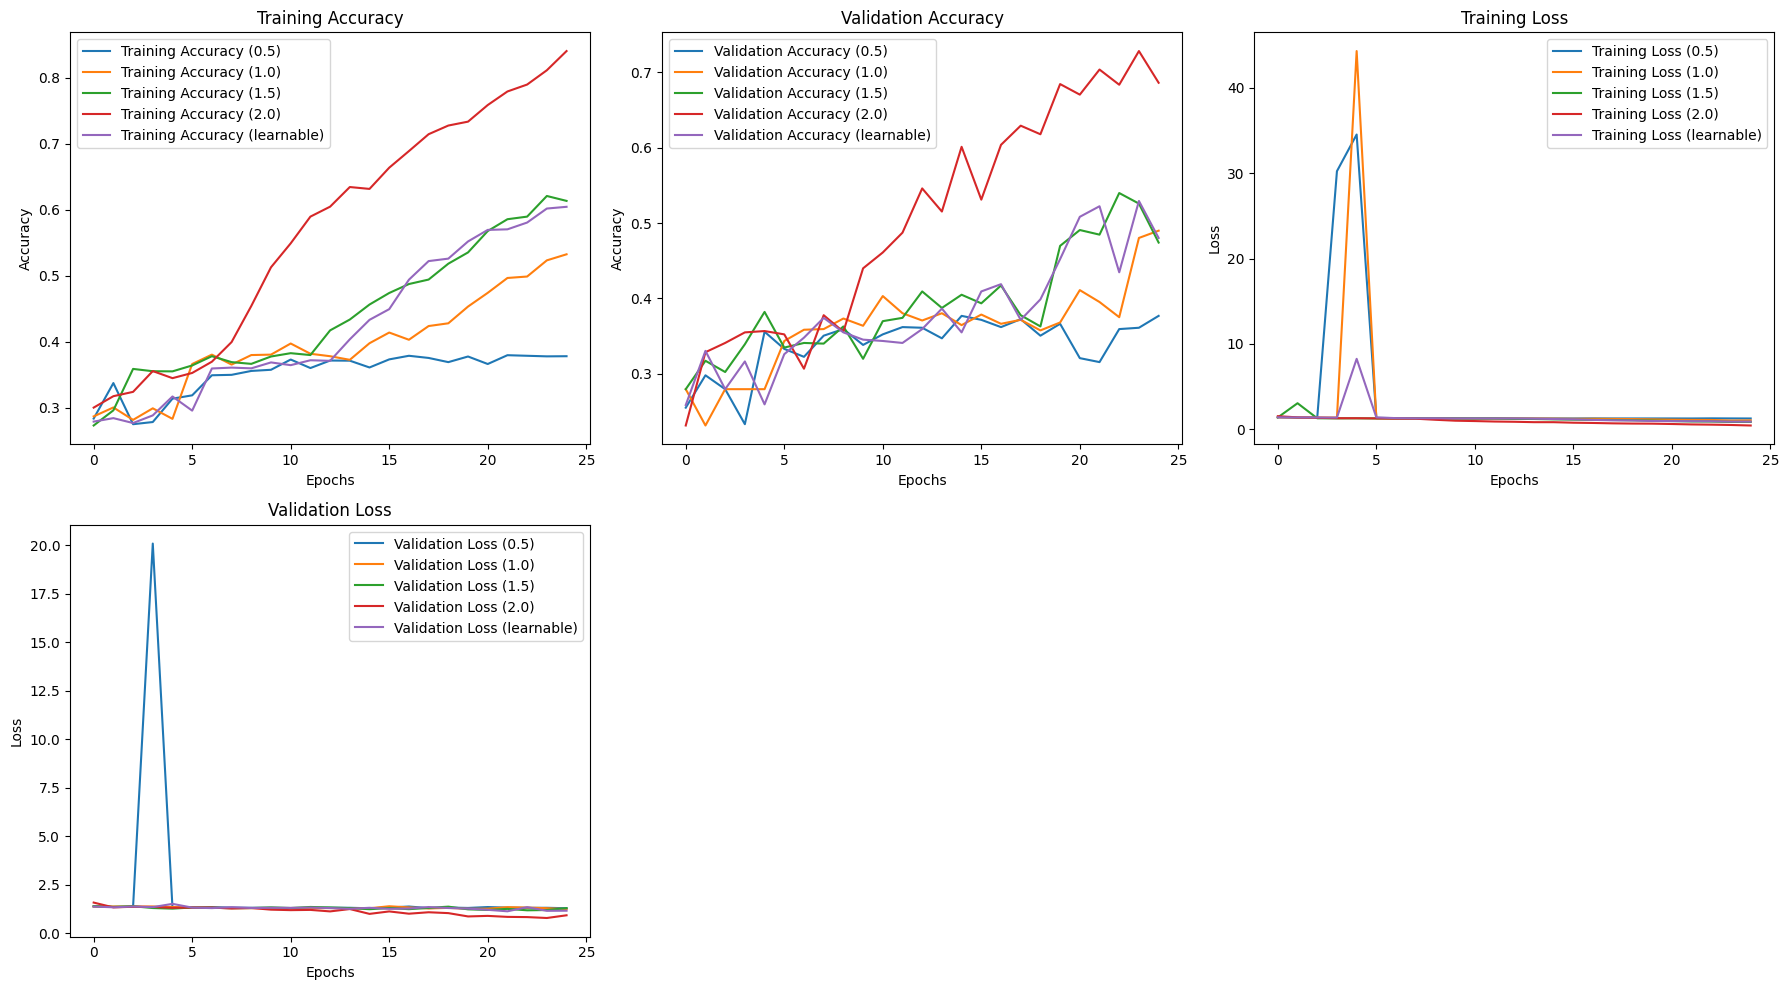

In [ ]:
static_alpha_results.append(history_learnable)
param_labels = [str(label) for label in alpha_values] #Initialize with alpha values
param_labels.append('learnable')
plot_training_history_multiple_models(static_alpha_results, param_labels)

# 3. Final Model Testing

In this section, we will aggregate the tuned and optimal hyperparameters identified during our tuning process to construct a "best model." Starting with the base architecture inspired by the VGG16 model, we integrate the optimal values for epochs, batch size, learning rate, and the Swish activation parameter—each derived from experiments yielding the best performance for the respective parameter. Whilst this approach does has theoretical floors, as combining individually optimized parameters does not guarantee optimal performance for the final model, it serves as a practical step to synthesize our findings into a unified model. Additionally, the purpose of this investigation was not to produce the best performing model possible but rather to evaluate and visualise the performance of models as we vary their hyperparameters.



### Implimenting the final model

Here we'll construct the proposed final moded with the following tuned hyperparameters:

1. Epochs =
2. Batch Size =
3. Learning rate:
4. Swish parameter, $α$ =

### Training the final model

### Testing the final model

### Scaling Up: Impact of Training on the Full 256x256 Dataset



# 4. Conclusion


In conclusion, this section of the report on the swish function has explored the nuanced impact of incorporating a linear term with the sigmoid function. This flexibility of swish with parameter $ \alpha $ and this aforementioned combination of terms works to bridge the previous section of this report, an investigation of ReLU with the next section of the report on the TanH activation function. Whilst Swish approximates the ReLU for low values of $ α $, its flexibility allows it to balance non-linearity and gradient behavior, working to target problems associated with ReLU such as gradient vanishing. As we progress through the report, a natural question might be, 'What happens when we explore the "purely sigmoidal" domain of activation functions?' or 'How does the abscence of the linear term influence the behaviour, weighting and performance of the model?'. This leads us to the following section of the report, namely our investigation on the Tanh activation function. By connecting these activation methods, we highlight a broader understanding of neural activation functions not as isolated mechanisms, but as more of a continious spectrum.

# 5. References - needs formalising

[1] https://millengustavo.github.io/handson-ml/ - for validation split

[2] https://image-net.org/ - for swish justification example

[3] https://arxiv.org/pdf/1710.05941 - swish justification

[4] file:///C:/Users/markm/Downloads/978-981-16-1086-8.pdf - swish for breast cancer detection

[5] https://www.geeksforgeeks.org/vgg-16-cnn-model/ - VGG16 model breakdown

[6] file:///C:/Users/markm/OneDrive/Documents/University/Year%204/dst/Week%207/Neural%20Nets%20and%20the%20Perceptron.pdf - introduction to swish

[7] https://www.mdpi.com/2227-7390/7/12/1170 - crc image classification

[8] https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/ - epochs and batch sizes

[9] https://ieeexplore.ieee.org/abstract/document/9344510 - learning rate

[10] https://arxiv.org/pdf/1910.11605 - learning rate

[11] https://arxiv.org/pdf/1608.03983 - warm restarts paper 1

[12] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8929465 - warm restarts paper 2

[13] https://image-net.org/ - imagenet

[14] https://www.bing.com/search?q=cifar+dataset&cvid=a9acdae763cb47cda9231f8e7fbe6c9d&gs_lcrp=EgRlZGdlKgkIABBFGDsY-QcyCQgAEEUYOxj5BzIGCAEQRRg5MgYIAhAjGCcyBggDECMYJzIGCAQQIxgnMgYIBRAjGCcyBggGEAAYQDIGCAcQABhAMgYICBBFGDzSAQgxMzgzajBqOagCCLACAQ&FORM=ANAB01&adppc=EDGEESS&PC=EDGEESS - cifar

[15] https://ar5iv.labs.arxiv.org/html/1810.13243

[16] https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts?_gl=1*5dolw6*_up*MQ..*_ga*MTU2ODI2MTQ5OS4xNzMxNzY1Mjk3*_ga_W0YLR4190T*MTczMTc2NTI5Ny4xLjAuMTczMTc2NTI5Ny4wLjAuMA.. - Cosine implimentation

[17] https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay?_gl=1*6en1x3*_up*MQ..*_ga*MTU2ODI2MTQ5OS4xNzMxNzY1Mjk3*_ga_W0YLR4190T*MTczMTc2NTI5Ny4xLjAuMTczMTc2NTI5Ny4wLjAuMA..

[18] https://arxiv.org/pdf/1801.07145

[19] https://paperswithcode.com/method/cosine-annealing - cosine annealing